# Synthetic control with `pymc` models

In [1]:
import arviz as az

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = cp.load_data("sc")
treatment_time = 70

## Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

### Convex Hull Assumption

The synthetic control method uses non-negative weights that sum to one. This means the synthetic control is a **convex combination** of the control units—it can only produce values within the range spanned by the controls at each time point.

:::{note}
For the method to work well, the treated unit's pre-intervention trajectory should lie within the "envelope" of the control units. If all controls are consistently above or below the treated unit, the method cannot construct an accurate counterfactual.
:::

CausalPy automatically checks this assumption when you create a `SyntheticControl` object and will issue a warning if violated. See the {term}`Convex hull condition` glossary entry and {cite:t}`abadie2010synthetic` for more details. The Augmented Synthetic Control Method {cite:p}`benmichael2021augmented` can handle cases where this assumption is violated.



In [4]:
df.head()

,a,b,c,d,e,f,g,counterfactual,causal effect,actual
0,0.793234,1.277264,-0.055407,-0.791535,1.075170,0.817384,-2.607528,0.144888,-0.0,0.398287
1,1.841898,1.185068,-0.221424,-1.430772,1.078303,0.890110,-3.108099,0.601862,-0.0,0.491644
2,2.867102,1.922957,-0.153303,-1.429027,1.432057,1.455499,-3.149104,1.060285,-0.0,1.232330
3,2.816255,2.424558,0.252894,-1.260527,1.938960,2.088586,-3.563201,1.520801,-0.0,1.672995
4,3.865208,2.358650,0.311572,-2.393438,1.977716,2.752152,-3.515991,1.983661,-0.0,1.775940


In [5]:
result = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=["a", "b", "c", "d", "e", "f", "g"],
    treated_units=["actual"],
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


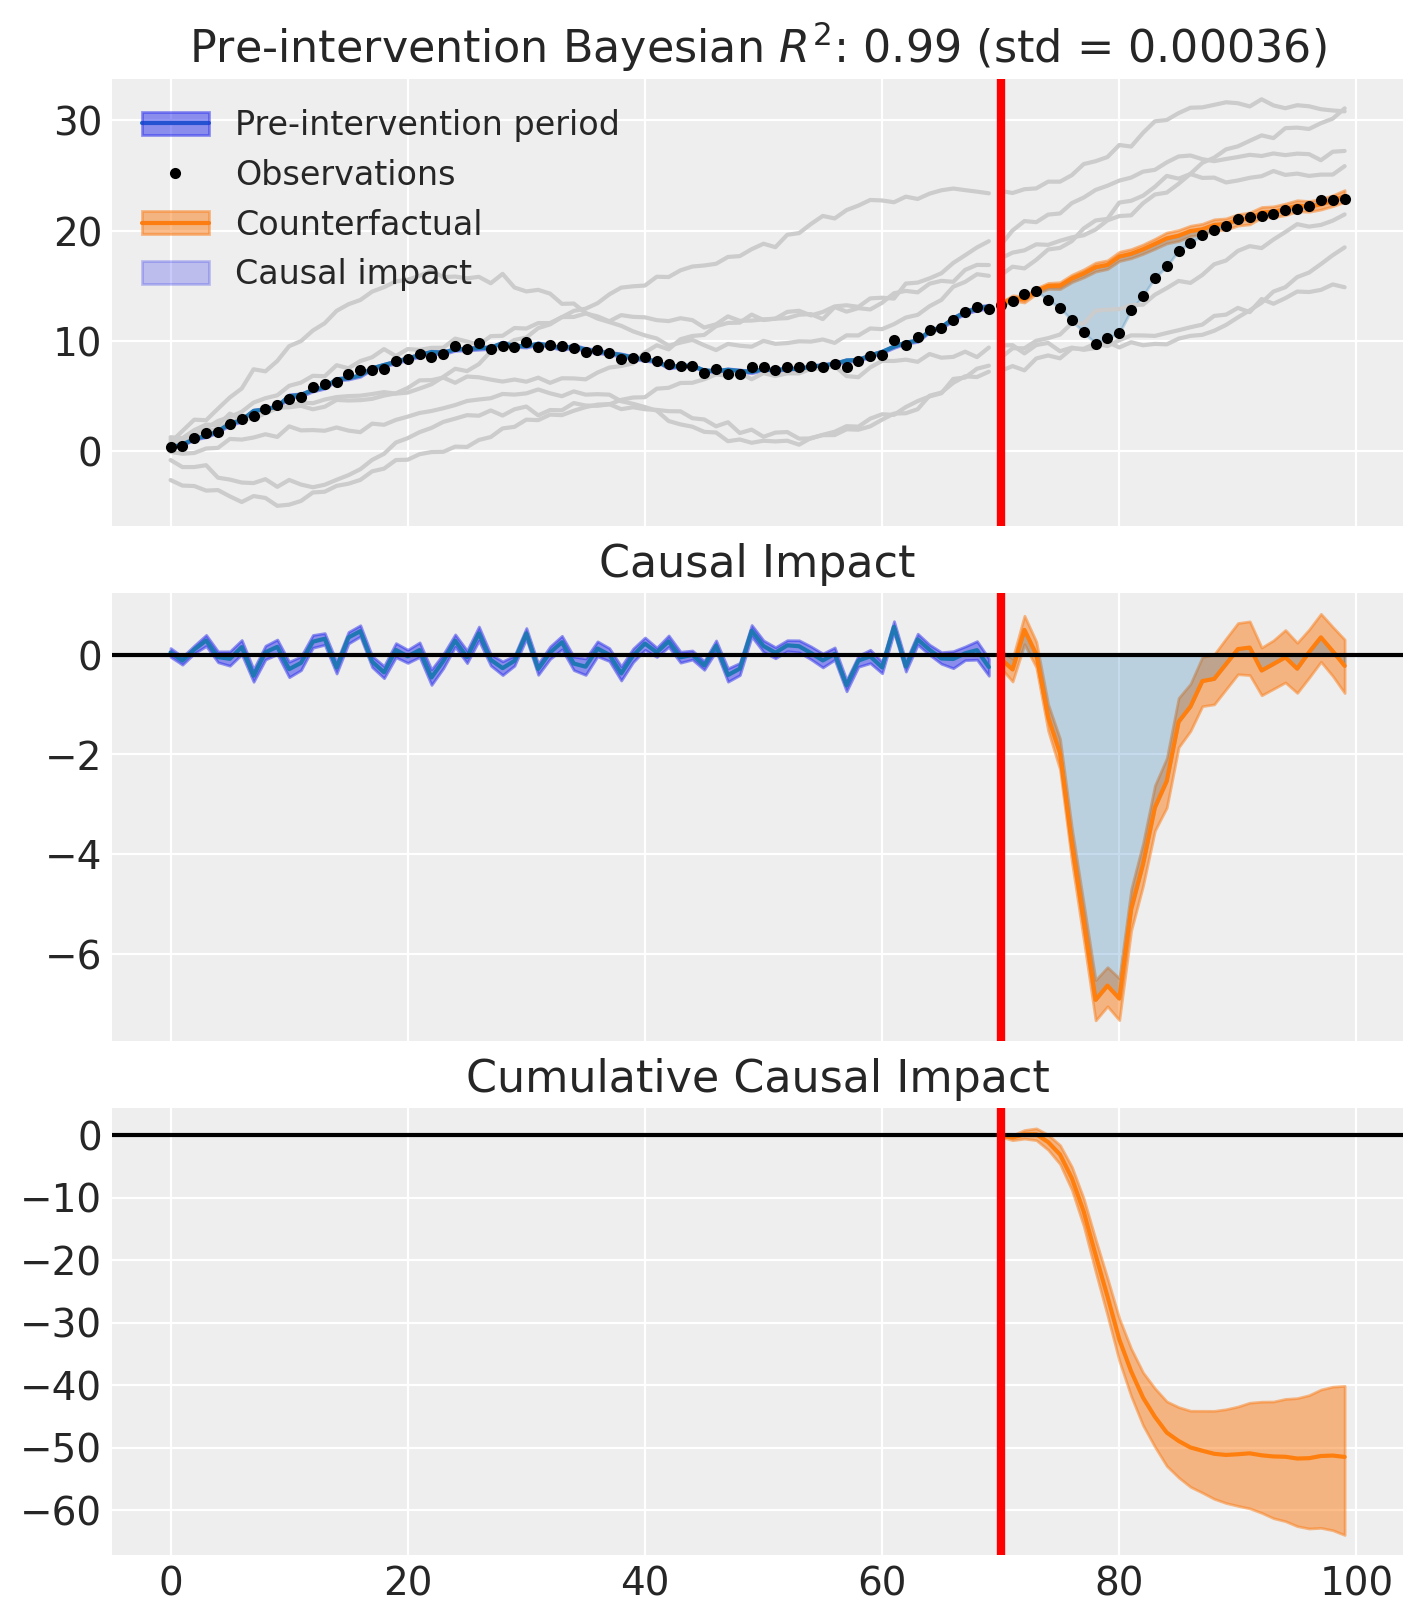

In [6]:
fig, ax = result.plot(plot_predictors=True)

In [7]:
result.summary()

================================SyntheticControl================================
Control units: ['a', 'b', 'c', 'd', 'e', 'f', 'g']
Treated unit: actual
Model coefficients:
    a            0.34, 94% HDI [0.3, 0.38]
    b            0.049, 94% HDI [0.01, 0.089]
    c            0.3, 94% HDI [0.26, 0.35]
    d            0.054, 94% HDI [0.0092, 0.099]
    e            0.026, 94% HDI [0.0015, 0.068]
    f            0.19, 94% HDI [0.1, 0.26]
    g            0.039, 94% HDI [0.0028, 0.09]
    y_hat_sigma  0.26, 94% HDI [0.22, 0.31]


As well as the model coefficients, we might be interested in the average causal impact and average cumulative causal impact.

In [8]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[actual],-1.717,0.216,-2.133,-1.338,0.006,0.003,1260.0,1812.0,1.0


:::{Warning}

Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [9]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[actual],-51.498,6.479,-63.982,-40.131,0.182,0.104,1260.0,1812.0,1.0


## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect with key statistics. The `effect_summary()` method provides a decision-ready report with average and cumulative effects, HDI intervals, tail probabilities, and relative effects.


In [10]:
# Generate effect summary for the full post-period
stats = result.effect_summary(treated_unit="actual")
stats.table

,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,-1.716602,-1.706684,-2.147102,-1.326032,0.0,-9.124018,-11.221693,-7.261266
cumulative,-51.498075,-51.200525,-64.413068,-39.780954,0.0,-9.124018,-11.221693,-7.261266


In [11]:
print(stats.text)

Post-period (70 to 99), the average effect was -1.72 (95% HDI [-2.15, -1.33]), with a posterior probability of an increase of 0.000. The cumulative effect was -51.50 (95% HDI [-64.41, -39.78]); probability of an increase 0.000. Relative to the counterfactual, this equals -9.12% on average (95% HDI [-11.22%, -7.26%]).


You can customize the summary in several ways:

- **Window**: Analyze a specific time period instead of the full post-period
- **Direction**: Specify whether you're testing for an increase, decrease, or two-sided effect
- **Options**: Include/exclude cumulative or relative effects


In [12]:
# Example: Analyze first half of post-period
post_indices = result.datapost.index
window_start = post_indices[0]
window_end = post_indices[len(post_indices) // 2]

stats_windowed = result.effect_summary(
    window=(window_start, window_end),
    treated_unit="actual",
    direction="two-sided",
    cumulative=True,
    relative=True,
)

stats_windowed.table

,mean,median,hdi_lower,hdi_upper,p_two_sided,prob_of_effect,relative_mean,relative_hdi_lower,relative_hdi_upper
average,-3.058950,-3.049049,-3.428534,-2.696519,0.0,1.0,-18.641865,-20.446211,-16.814846
cumulative,-48.943206,-48.784789,-54.856540,-43.144308,0.0,1.0,-18.641865,-20.446211,-16.814846


In [13]:
print(stats_windowed.text)

Post-period (70 to 85), the average effect was -3.06 (95% HDI [-3.43, -2.70]), with a posterior probability of an effect of 1.000. The cumulative effect was -48.94 (95% HDI [-54.86, -43.14]); probability of an effect 1.000. Relative to the counterfactual, this equals -18.64% on average (95% HDI [-20.45%, -16.81%]).


## Sensitivity analysis

Synthetic control designs support a rich set of sensitivity checks. Below we run four in a single pipeline:

- **ConvexHullCheck** — verifies the treated unit lies within the convex hull of the controls (instant, no refitting).
- **LeaveOneOut** — drops each control unit in turn and refits, checking effect stability.
- **PlaceboInSpace** — treats each control unit as if it were treated, looking for spurious effects.
- **PlaceboInTime** — shifts the treatment time to pre-intervention periods, testing for spurious effects.

This is computationally expensive because it involves multiple MCMC refits.

In [14]:
sensitivity_result = cp.Pipeline(
    data=df,
    steps=[
        cp.EstimateEffect(
            method=cp.SyntheticControl,
            treatment_time=treatment_time,
            control_units=["a", "b", "c", "d", "e", "f", "g"],
            treated_units=["actual"],
            model=cp.pymc_models.WeightedSumFitter(
                sample_kwargs={"target_accept": 0.95, "random_seed": seed}
            ),
        ),
        cp.SensitivityAnalysis(
            checks=[
                cp.checks.ConvexHullCheck(),
                cp.checks.LeaveOneOut(),
                cp.checks.PlaceboInSpace(),
                cp.checks.PlaceboInTime(n_folds=3),
            ],
        ),
        cp.GenerateReport(include_plots=True),
    ],
).run()

for cr in sensitivity_result.sensitivity_results:
    print(cr.text)
    print()

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/git/CausalPy/causalpy/experiments/synthetic_control.py:107: UserWarning: Convex hull assumption may be violated: 1 pre-intervention time points (1.4% above, 0.0% below control range). The synthetic control method requires the treated unit to lie within the convex hull of control units. Consider: (1) adding more diverse control units, (2) using a model with an intercept (e.g., ITS with control predictors), or (3) using the Augmented Synthetic Control Method. See glossary term 'Convex hull condition' for more details.
  self._check_convex_hull()


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/git/CausalPy/causalpy/experiments/synthetic_control.py:107: UserWarning: Convex hull assumption may be violated: 34 pre-intervention time points (48.6% above, 0.0% below control range). The synthetic control method requires the treated unit to lie within the convex hull of control units. Consider: (1) adding more diverse control units, (2) using a model with an intercept (e.g., ITS with control predictors), or (3) using the Augmented Synthetic Control Method. See glossary term 'Convex hull condition' for more details.
  self._check_convex_hull()


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/git/CausalPy/causalpy/experiments/synthetic_control.py:107: UserWarning: Convex hull assumption may be violated: 1 pre-intervention time points (1.4% above, 0.0% below control range). The synthetic control method requires the treated unit to lie within the convex hull of control units. Consider: (1) adding more diverse control units, (2) using a model with an intercept (e.g., ITS with control predictors), or (3) using the Augmented Synthetic Control Method. See glossary term 'Convex hull condition' for more details.
  self._check_convex_hull()


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/git/CausalPy/causalpy/experiments/synthetic_control.py:107: UserWarning: Convex hull assumption may be violated: 24 pre-intervention time points (0.0% above, 34.3% below control range). The synthetic control method requires the treated unit to lie within the convex hull of control units. Consider: (1) adding more diverse control units, (2) using a model with an intercept (e.g., ITS with control predictors), or (3) using the Augmented Synthetic Control Method. See glossary term 'Convex hull condition' for more details.
  self._check_convex_hull()


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/git/CausalPy/causalpy/experiments/synthetic_control.py:107: UserWarning: Convex hull assumption may be violated: 2 pre-intervention time points (0.0% above, 2.9% below control range). The synthetic control method requires the treated unit to lie within the convex hull of control units. Consider: (1) adding more diverse control units, (2) using a model with an intercept (e.g., ITS with control predictors), or (3) using the Augmented Synthetic Control Method. See glossary term 'Convex hull condition' for more details.
  self._check_convex_hull()


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/git/CausalPy/causalpy/experiments/synthetic_control.py:107: UserWarning: Convex hull assumption may be violated: 35 pre-intervention time points (50.0% above, 0.0% below control range). The synthetic control method requires the treated unit to lie within the convex hull of control units. Consider: (1) adding more diverse control units, (2) using a model with an intercept (e.g., ITS with control predictors), or (3) using the Augmented Synthetic Control Method. See glossary term 'Convex hull condition' for more details.
  self._check_convex_hull()


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/git/CausalPy/causalpy/experiments/synthetic_control.py:107: UserWarning: Convex hull assumption may be violated: 44 pre-intervention time points (0.0% above, 62.9% below control range). The synthetic control method requires the treated unit to lie within the convex hull of control units. Consider: (1) adding more diverse control units, (2) using a model with an intercept (e.g., ITS with control predictors), or (3) using the Augmented Synthetic Control Method. See glossary term 'Convex hull condition' for more details.
  self._check_convex_hull()


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Fold 1 failed to fit (pseudo_treatment_time=-17), skipping.


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Convex hull check passed: all treated unit values lie within the range of control units in the pre-treatment period.

Leave-one-out analysis: dropped each of 7 control units. Examine the table for consistency of effect estimates.

Placebo-in-space analysis: tested 7 control units as placebo treated units. If placebo effects are comparable to the actual effect, the causal claim may be weakened.

Placebo-in-time analysis: 2 of 3 folds completed (1 skipped).
PASSED — no spurious effects detected in any fold.
Fold 1: SKIPPED (experiment failed to fit at pseudo treatment time -17)
Fold 2: pseudo treatment at 12 — PASS (null)
Fold 3: pseudo treatment at 41 — PASS (null)




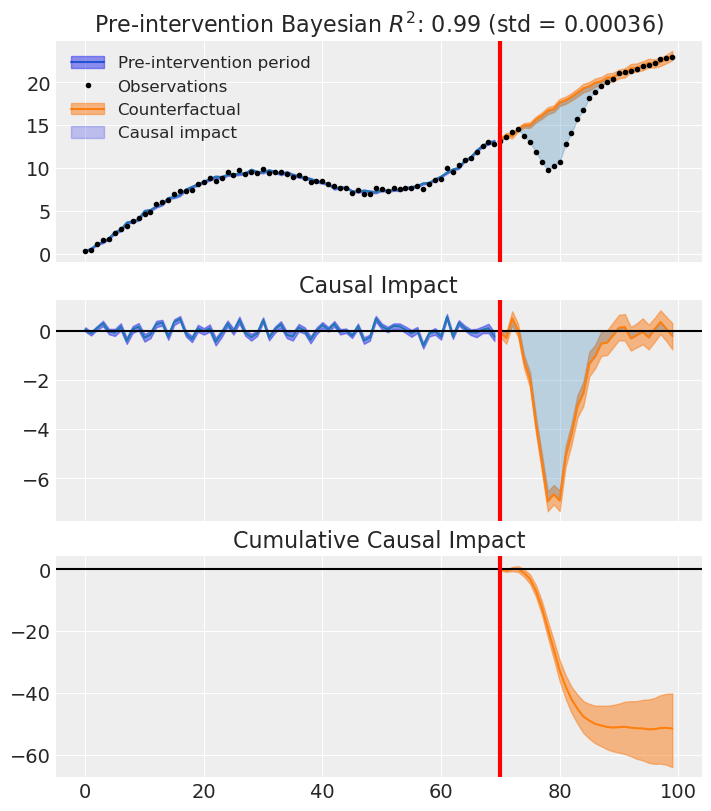

In [15]:
import html as html_module
import warnings

from IPython.display import HTML

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", "Consider using IPython.display.IFrame", UserWarning
    )
    display(
        HTML(
            f'<iframe srcdoc="{html_module.escape(sensitivity_result.report)}" '
            f'width="100%" height="600" style="border:1px solid #ccc;"></iframe>'
        )
    )

## References
:::{bibliography}
:filter: docname in docnames
:::